# Problem Statement: Parsing a Linux Systekm Log file and analyse

1. Parses a Linux-like log file (huge_test_log.txt) for system failure details
```
[2025-06-05 10:15:23] COMPONENT:NetworkManager STATUS:FAIL ERROR:1001
[2025-06-05 10:16:00] COMPONENT:DiskMonitor STATUS:SUCCESS ERROR:0
[2025-06-05 10:17:45] COMPONENT:USBDriver STATUS:FAIL ERROR:2002
[2025-06-05 10:18:10] COMPONENT:NetworkManager STATUS:SUCCESS ERROR:0
[2025-06-05 10:19:30] COMPONENT:FileSystem STATUS:FAIL ERROR:3001
```
2. Extracts component name, status, timestamp, error code

3. Saves the data into a CSV file

4. Analyzes it using pandas

5. Generates an HTML file with code, explanation, output, and analysis

In [43]:
#1
import re
import pandas as pd
LinesLimit = 200

def parse_log_data(file_name):
    global LinesLimit
    LinesLimit = 200

    result_data = []
    with open(file_name) as fd:
        print("Opened file")
        for line in fd:
            if LinesLimit == 0:
                break
            LinesLimit -= 1
            parsed = re.search(r'\[(.*)\] COMPONENT:(\w+) STATUS:(\w+) ERROR:(\d+)', line)
            date, component, status, errno = parsed.groups()
            result_data.append({
                                "date":date,
                                "component": component,
                                "status":status,
                                "errno":int(errno)})
            
    return result_data
    
data = parse_log_data("data/huge_test_log.txt")
df = pd.DataFrame(data)

# 2. Get idea
print(df.head())
print(df.columns)
# list only failure
all_failures = df[df['status']=="FAIL"]
print(all_failures)


Opened file
                  date        component   status  errno
0  2025-05-26 15:28:30     LoadBalancer     FAIL   4002
1  2025-05-26 15:32:51  DatabaseService  SUCCESS      0
2  2025-05-26 15:36:27      AuthService  SUCCESS      0
3  2025-05-26 15:38:46       APIGateway  SUCCESS      0
4  2025-05-26 15:43:16     LoadBalancer     FAIL   2002
Index(['date', 'component', 'status', 'errno'], dtype='object')
                    date       component status  errno
0    2025-05-26 15:28:30    LoadBalancer   FAIL   4002
4    2025-05-26 15:43:16    LoadBalancer   FAIL   2002
5    2025-05-26 15:46:21     AuthService   FAIL   5002
6    2025-05-26 15:48:36      FileSystem   FAIL   4001
7    2025-05-26 15:52:05     AuthService   FAIL   5001
..                   ...             ...    ...    ...
190  2025-05-26 23:39:06     DiskMonitor   FAIL   4001
191  2025-05-26 23:39:45       WebServer   FAIL   1001
193  2025-05-26 23:46:52       USBDriver   FAIL   2003
197  2025-05-26 23:53:28  NetworkManag

Opened file


<Axes: >

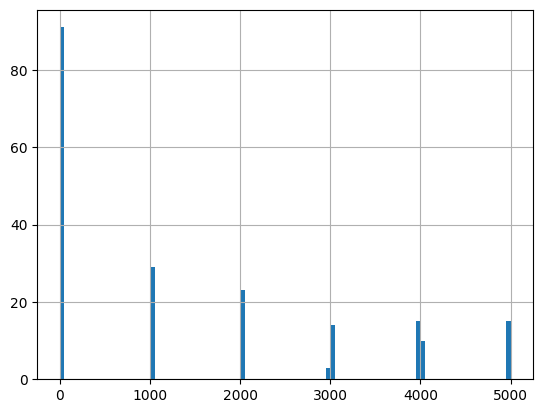

In [48]:
data = parse_log_data("data/huge_test_log.txt")
df = pd.DataFrame(data)

df["errno"].hist(bins=100)

In [61]:
err_count_per_comp = df.groupby('component')['errno'].count().sort_values()
print(err_count_per_comp)
print(type(err_count_per_comp))
print(df[0:3])

component
APIGateway         11
WebServer          13
LoadBalancer       14
NetworkManager     14
DiskMonitor        15
FileSystem         15
SecurityAgent      15
CacheService       16
BillingEngine      17
USBDriver          22
AuthService        24
DatabaseService    24
Name: errno, dtype: int64
<class 'pandas.core.series.Series'>
                  date        component   status  errno
0  2025-05-26 15:28:30     LoadBalancer     FAIL   4002
1  2025-05-26 15:32:51  DatabaseService  SUCCESS      0
2  2025-05-26 15:36:27      AuthService  SUCCESS      0


                 date        component   status  errno
0 2025-05-26 15:28:30     LoadBalancer     FAIL   4002
1 2025-05-26 15:32:51  DatabaseService  SUCCESS      0
2 2025-05-26 15:36:27      AuthService  SUCCESS      0
3 2025-05-26 15:38:46       APIGateway  SUCCESS      0
4 2025-05-26 15:43:16     LoadBalancer     FAIL   2002
5 2025-05-26 15:46:21      AuthService     FAIL   5002
6 2025-05-26 15:48:36       FileSystem     FAIL   4001
7 2025-05-26 15:52:05      AuthService     FAIL   5001
8 2025-05-26 15:56:41       FileSystem     FAIL   3002
9 2025-05-26 16:01:17     LoadBalancer     FAIL   4001
                   date       component   status  errno
199 2025-05-26 23:57:29    CacheService     FAIL   2003
198 2025-05-26 23:53:47      APIGateway  SUCCESS      0
197 2025-05-26 23:53:28  NetworkManager     FAIL   4002
196 2025-05-26 23:52:49      APIGateway  SUCCESS      0
195 2025-05-26 23:49:58  NetworkManager  SUCCESS      0
194 2025-05-26 23:47:58    LoadBalancer  SUCCESS      0
193

<Axes: xlabel='component'>

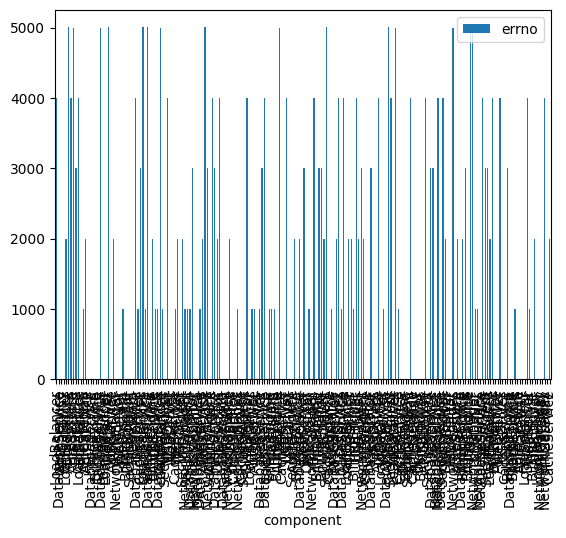

In [81]:
import datetime

df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S")
print(df[:10])
df_sorted = df.sort_values(by='date', ascending=False)
print(df_sorted[:10])
df.plot(x='component', y='errno', kind='bar')

In [119]:
import pandas as pd
import re
from datetime import datetime

# 1. Read and parse the log file
log_entries = []
pattern = r"\[(.*?)\] COMPONENT:(.*?) STATUS:(.*?) ERROR:(\d+)"

with open("data/huge_test_log.txt", "r") as file:
    for line in file:
        match = re.search(pattern, line)
        if match:
            timestamp_str, component, status, error = match.groups()
            timestamp = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S")
            log_entries.append({
                "Timestamp": timestamp,
                "Component": component,
                "Status": status,
                "ErrorCode": int(error)
            })

# 2. Create a DataFrame and save to CSV
df = pd.DataFrame(log_entries)
df.to_csv("parsed_logs.csv", index=False)

# 3. Basic Analysis using pandas
#summary = df.groupby('Component')['ErrorCode'].count()
#summary = df.groupby(['Component', 'Status']).count().unstack(fill_value=0)
summary = df.groupby(['Component', 'Status']).size().unstack(fill_value=0)

failures = df[df["Status"] == "FAIL"]

print(summary)
print(failures)
# 4. Export analysis to HTML
with open("log_analysis.html", "w") as f:
    f.write("<h2>Parsed Log Data</h2>")
    f.write(summary.to_html(index=False))

print(type(summary))

Status           FAIL  SUCCESS
Component                     
APIGateway       4159     4257
AuthService      4225     4176
BillingEngine    4025     4191
CacheService     4186     4088
DatabaseService  4139     4124
DiskMonitor      4178     4271
FileSystem       4176     4161
LoadBalancer     4197     4209
NetworkManager   4105     4163
SecurityAgent    4162     4258
USBDriver        4080     4135
WebServer        4180     4155
                Timestamp        Component Status  ErrorCode
0     2025-05-26 15:28:30     LoadBalancer   FAIL       4002
4     2025-05-26 15:43:16     LoadBalancer   FAIL       2002
5     2025-05-26 15:46:21      AuthService   FAIL       5002
6     2025-05-26 15:48:36       FileSystem   FAIL       4001
7     2025-05-26 15:52:05      AuthService   FAIL       5001
...                   ...              ...    ...        ...
99990 2025-11-16 20:56:00  DatabaseService   FAIL       1002
99991 2025-11-16 20:56:50       APIGateway   FAIL       3002
99994 2025-11-16 

In [116]:
df2 = df.query("ErrorCode == 4002")
print(len(df2))
print(df2.size)
print(df.size)

3861
15444
400000


In [115]:
print(3861*4)

15444


# Problem Statement: Titanic Survivors Analysis

In [137]:
import seaborn as sb
df = sb.load_dataset('titanic')

df.describe()
df = df.dropna(subset=['age'])

In [138]:
survived = df[df['survived']==1]
print(len(survived), len(df), 100*(len(survived)/len(df)))
sorted_age = survived.sort_values('age', ascending=False)
print(sorted_age[:10])

290 714 40.61624649859944
     survived  pclass     sex   age  ...  deck  embark_town  alive  alone
630         1       1    male  80.0  ...     A  Southampton    yes   True
275         1       1  female  63.0  ...     D  Southampton    yes  False
483         1       3  female  63.0  ...   NaN  Southampton    yes   True
829         1       1  female  62.0  ...     B          NaN    yes   True
570         1       2    male  62.0  ...   NaN  Southampton    yes   True
366         1       1  female  60.0  ...     D    Cherbourg    yes  False
587         1       1    male  60.0  ...     B    Cherbourg    yes  False
268         1       1  female  58.0  ...     C  Southampton    yes  False
11          1       1  female  58.0  ...     C  Southampton    yes   True
195         1       1  female  58.0  ...     B    Cherbourg    yes   True

[10 rows x 15 columns]


In [159]:
fatal = df[df['survived']==0]
survived = df[df['survived']==1]
fatal = fatal.groupby('age').agg({'survived':'count'}).rename(columns={'survived':'Fatal'})
sur = survived.groupby('age').agg({'survived':'count'}).rename({"survived":"Survived"})

final = pd.merge(sur, fatal, left_index=True, right_index=True, how='outer')

final = final.fillna(0)
print(final.loc[:10])


       survived  Fatal
age                   
0.42        1.0    0.0
0.67        1.0    0.0
0.75        2.0    0.0
0.83        2.0    0.0
0.92        1.0    0.0
1.00        5.0    2.0
2.00        3.0    7.0
3.00        5.0    1.0
4.00        7.0    3.0
5.00        4.0    0.0
6.00        2.0    1.0
7.00        1.0    2.0
8.00        2.0    2.0
9.00        2.0    6.0
10.00       0.0    2.0
